# 05.2 Solving Parabolic Equations Numerically
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**

- Localise a parabolic pricing PDE on a bounded space domain.
- Build a finite-difference discretisation in space and time.
- mplement the θ-scheme (explicit, implicit, Crank–Nicolson).
- Solve the resulting tridiagonal linear systems efficiently.
- Apply the method to the Black–Scholes PDE in log-space.
- Compare the numerical solution to the closed-form Black–Scholes price and visualise the solution surface.

**This notebook**

Takes the pricing PDE from 05.1 and makes it fully numerical.
We start from the continuous Feynman–Kac representation, restrict the domain, discretise derivatives, and build a stable time-stepping scheme.
At the end we obtain a working PDE engine for European call prices, with error diagnostics and plots.

## 1. From PDE on $\mathbb{R}$ to a bounded domain (localisation)

In 05.1 the price function $u(t,x)$ solves, for a diffusion $X$ and rate $r$,

$$\partial_t u(t,x) + (A_t u)(t,x) - r(t,x)\, u(t,x) = 0, \quad u(T,x) = f(x), \quad x \in \mathbb{R}.$$

Numerically, we cannot work on the whole real line, so we truncate space to an interval

$$x \in (-\ell, \ell).$$

For diffusions with Gaussian tails (e.g. log-price in Black–Scholes), the error induced by truncation can be controlled.
For instance, for a Brownian motion with volatility $\sigma$ and bounded payoff $|f| \leq M$, one can show

$$\left|u(t,x) - u_\ell(t,x)\right| \leq M\, \mathbb{P}\!\left(\sup_{s \in [t,T]} |X_s| \geq \ell\right) \lesssim M\left(e^{-(\ell - |x|)^2/(\sigma^2 T)} + e^{-(\ell + |x|)^2/(\sigma^2 T)}\right),$$

so choosing $\ell$ a few standard deviations away from the region of interest makes the truncation error negligible.

We also need boundary conditions on $(t,x) \in [0,T] \times \{-\ell, \ell\}$:

For European calls in $S$-space:

- as $S \to 0$, $u(t,S) \to 0$ ⇒ Dirichlet $u(t,S_{\min}) \approx 0$;
- as $S \to \infty$, $u(t,S) \sim S - Ke^{-r(T-t)}$ ⇒ linear boundary at $S_{\max}$.

In log-space $x = \ln S$, these translate into conditions at $x_{\min}, x_{\max}$.


## 2. Space–time grid

We work on a uniform grid:

**Space:**

$$x_i = x_{\min} + ih, \quad i=0,\ldots,N, \quad h=\frac{x_{\max}-x_{\min}}{N}.$$

**Time (backward):**

$$t_n = nk, \quad n=0,\ldots,M, \quad k=\frac{T}{M},$$

and we evolve backward from $t_M = T$ to $t_0 = 0$.

We denote by $u_i^n \approx u(t_n, x_i)$.

- **Interior points:** $i=1,\ldots,N-1$.
- **Boundary points:** $i=0$ and $i=N$ (Dirichlet or other conditions).


## 3. Finite differences for first and second derivatives

On the uniform grid, central differences give:

**First derivative:**

$$u_x(t_n, x_i) \approx \frac{u_{i+1}^n - u_{i-1}^n}{2h},$$

**Second derivative:**

$$u_{xx}(t_n, x_i) \approx \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{h^2}.$$

In log-Black–Scholes, we work with $x = \ln S$ and PDE

$$\partial_t v + \frac{1}{2}\sigma^2 v_{xx} + \left(r - \frac{1}{2}\sigma^2\right)v_x - rv = 0, \quad v(T,x) = f(e^x).$$

At grid point $(t_n, x_i)$, the discrete spatial operator $(A_h v^n)_i$ is

$$(A_h v^n)_i = \frac{1}{2}\sigma^2 \frac{v_{i+1}^n - 2v_i^n + v_{i-1}^n}{h^2} + \left(r - \frac{1}{2}\sigma^2\right)\frac{v_{i+1}^n - v_{i-1}^n}{2h} - rv_i^n.$$

This is a tridiagonal operator: each row only couples $i-1, i, i+1$.




$$A_h = \begin{bmatrix}
\cdot & \cdot & 0 & 0 & \cdots & 0 \\
\cdot & \cdot & \cdot & 0 & \cdots & 0 \\
0 & \cdot & \cdot & \cdot & 0 & \cdots \\
\vdots & & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & 0 & \cdot & \cdot & \cdot \\
0 & \cdots & 0 & 0 & \cdot & \cdot
\end{bmatrix}$$



## 4. θ-scheme in time

We discretise the PDE

$$v_t + Av = 0$$

by a θ-scheme:

$$\frac{v_i^{n+1} - v_i^n}{k} + \theta(A_h v^n)_i + (1-\theta)(A_h v^{n+1})_i = 0.$$

Equivalently,

$$(I - k(1-\theta)A_h)v^{n+1} = (I + k\theta A_h)v^n.$$

We step backward in time from $n = M-1, \ldots, 0$; at each step we solve a linear system.

Special cases:

- $\theta = 0$: explicit scheme (conditionally stable, requires $k/h^2$ small).

- $\theta = \frac{1}{2}$: Crank–Nicolson, second order in time, unconditionally stable for parabolic operators.

- $\theta = 1$: fully implicit, first order in time, unconditionally stable.

In practice for pricing we often pick $\theta = \frac{1}{2}$ (Crank–Nicolson) or a slightly damped version.


## 5. Implementing the tridiagonal system

On the interior points $i=1,\ldots,N-1$, the spatial operator gives coefficients:

$$(A_h v)_i = a_i v_{i-1} + b_i v_i + c_i v_{i+1},$$

where, for log-Black–Scholes,

$$a_i = \frac{1}{2}\sigma^2 \frac{1}{h^2} - \left(r - \frac{1}{2}\sigma^2\right) \frac{1}{2h},$$

$$b_i = -\frac{\sigma^2}{h^2} - r,$$

$$c_i = \frac{1}{2}\sigma^2 \frac{1}{h^2} + \left(r - \frac{1}{2}\sigma^2\right) \frac{1}{2h}.$$

The $\theta$-scheme leads to a tridiagonal linear system of the form

$$R u^n = G(u^{n+1}),$$

where $R$ has diagonal and off-diagonals that we can precompute, and $G$ is a known vector depending on $u^{n+1}$ and boundary values.

We solve the tridiagonal system with the Thomas algorithm (specialised Gaussian elimination in $O(N)$).


# 6. Utility: Black–Scholes closed-form call price
We will use the closed-form solution to benchmark our PDE solver.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore")

In [2]:
def bs_call_price(S0, K, T, r, sigma):
    """Black–Scholes call price (European)."""
    if T <= 0:
        return max(S0 - K, 0.0)
    vol_sqrt_T = sigma * np.sqrt(T)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / vol_sqrt_T
    d2 = d1 - vol_sqrt_T
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# 7. Tridiagonal solver (Thomas algorithm)

In [3]:
def thomas_tridiagonal(a, b, c, d):
    """
    Solve a tridiagonal system Ax = d with A having:
    - a: sub-diagonal (size N-1)
    - b: main diagonal (size N)
    - c: super-diagonal (size N-1)
    
    Returns x (size N).
    """
    n = len(b)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))  # copies
    
    # Forward sweep
    for i in range(1, n):
        w = ac[i-1] / bc[i-1]
        bc[i] = bc[i] - w * cc[i-1]
        dc[i] = dc[i] - w * dc[i-1]
    
    # Back substitution
    x = np.zeros(n)
    x[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    
    return x

# 8. Building the BS operator coefficients in log-space

We work with the PDE for $v(t,x)$ where $x=\ln S$.
We precompute the coefficients of the discrete operator and the θ-scheme matrices.


In [4]:
def build_bs_log_coeffs(x_grid, r, sigma, h):
    """
    Build spatial coefficients a_i, b_i, c_i for the log-BS operator
    on the interior nodes i = 1,...,N-1.
    """
    N = len(x_grid) - 1  # indices 0..N
    a = np.zeros(N-1)
    b = np.zeros(N-1)
    c = np.zeros(N-1)
    
    for i in range(1, N):
        # same coefficients for all i in log-BS (since coefficients do not depend on x)
        a_i = 0.5 * sigma**2 / h**2 - (r - 0.5 * sigma**2) / (2 * h)
        b_i = -sigma**2 / h**2 - r
        c_i = 0.5 * sigma**2 / h**2 + (r - 0.5 * sigma**2) / (2 * h)
        a[i-1] = a_i
        b[i-1] = b_i
        c[i-1] = c_i
    
    return a, b, c

# 9. θ-scheme solver for the BS PDE (log-space)

We now implement a generic solver:

- grid in $x$ (log-price),
- grid in $t$,
- $\theta$ parameter,
- call payoff,
- approximate Dirichlet boundary conditions.


In [5]:
def solve_bs_pde_log(
    S0, K, T, r, sigma,
    x_min, x_max,
    N_x=200, N_t=200,
    theta=0.5
):
    """
    Solve the BS PDE for a European call in log-space:
        v_t + (1/2 sigma^2) v_xx + (r - sigma^2/2) v_x - r v = 0
    on [0,T] x [x_min, x_max] using a theta-scheme.
    
    Returns:
        t_grid (M+1),
        x_grid (N+1),
        V     ((M+1) x (N+1)) with V[n, i] ≈ v(t_n, x_i)
    """
    # grids
    x_grid = np.linspace(x_min, x_max, N_x + 1)
    h = x_grid[1] - x_grid[0]
    t_grid = np.linspace(0.0, T, N_t + 1)
    k = t_grid[1] - t_grid[0]
    
    # payoff at maturity (n = N_t)
    S_grid = np.exp(x_grid)
    payoff = np.maximum(S_grid - K, 0.0)
    
    # storage: V[n, i]
    V = np.zeros((N_t + 1, N_x + 1))
    V[-1, :] = payoff  # terminal condition
    
    # spatial coefficients
    a, b, c = build_bs_log_coeffs(x_grid, r, sigma, h)
    
    # precompute R and G structure for interior points
    # size interior = N_x - 1
    N_int = N_x - 1
    
    # diagonals for matrix R = I - k(1-theta) A_h
    a_R = -(1 - theta) * k * a       # sub-diagonal
    b_R = 1 - (1 - theta) * k * b    # main diagonal
    c_R = -(1 - theta) * k * c       # super-diagonal
    
    # diagonals for matrix L = I + k theta A_h  (used on RHS)
    a_L = theta * k * a
    b_L = 1 + theta * k * b
    c_L = theta * k * c
    
    # backward in time: from n = N_t-1 down to 0
    for n in range(N_t - 1, -1, -1):
        # previous time level is n+1, we compute V[n,:]
        V_next = V[n+1, :].copy()
        
        # RHS for interior points
        rhs = np.zeros(N_int)
        for i in range(1, N_x):  # interior indices
            idx = i - 1
            rhs[idx] = (
                a_L[idx] * V_next[i-1] +
                b_L[idx] * V_next[i] +
                c_L[idx] * V_next[i+1]
            )
        
        # boundary conditions at time t_n
        t = t_grid[n]
        # S at boundaries
        S_left = np.exp(x_grid[0])
        S_right = np.exp(x_grid[-1])
        
        # left boundary: call close to 0 for small S
        V_left = 0.0
        
        # right boundary: asymptotic behaviour ~ S - K e^{-r(T-t)}
        V_right = S_right - K * np.exp(-r * (T - t))
        
        # impact of boundary conditions on RHS (Dirichlet)
        rhs[0]   -= a_R[0]   * V_left
        rhs[-1]  -= c_R[-1]  * V_right
        
        # solve tridiagonal system for interior
        V_int = thomas_tridiagonal(a_R, b_R, c_R, rhs)
        
        # update V at time n
        V[n, 0]     = V_left
        V[n, -1]    = V_right
        V[n, 1:-1]  = V_int
    
    return t_grid, x_grid, V

# 10. Numerical experiment: European call in BS

We now compare:

- the PDE solution $v(0,\ln S)$ at $t=0$ for various $S$,
- the Black–Scholes closed-form price.

We expect the PDE and BS prices to be close, with an error driven by: truncation (finite domain), discretisation in 𝑡 and 𝑥

In [6]:
# Parameters
S0 = 100.0
K = 100.0
r = 0.05
sigma = 0.2
T = 1.0

# Spatial domain in log-space
x0 = np.log(S0)
L = 4.0  # covers a wide range of prices
x_min = x0 - L
x_max = x0 + L

# Grid sizes
N_x = 200
N_t = 200
theta = 0.5  # Crank–Nicolson

t_grid, x_grid, V = solve_bs_pde_log(
    S0=S0, K=K, T=T,
    r=r, sigma=sigma,
    x_min=x_min, x_max=x_max,
    N_x=N_x, N_t=N_t,
    theta=theta
)

# Extract t=0 slice (n=0)
V0 = V[0, :]
S_grid = np.exp(x_grid)

# Black–Scholes prices for comparison
bs_prices = np.array([bs_call_price(S, K, T, r, sigma) for S in S_grid])

# Interpolate PDE price at S0
# find closest index
idx0 = np.argmin(np.abs(S_grid - S0))
pde_S0 = V0[idx0]
bs_S0 = bs_call_price(S0, K, T, r, sigma)

pde_S0, bs_S0, abs(pde_S0 - bs_S0)


(np.float64(10.414235816469121),
 np.float64(10.450583572185565),
 np.float64(0.03634775571644333))

PDE price at $S_0 = 100$: ≈ 10.414

Black–Scholes closed-form: ≈ 10.451

Absolute error: ≈ 0.036 → about 0.35% of the BS price.

So our Crank–Nicolson PDE solver in log-space reproduces the BS price very accurately.
The small gap is just numerical error (finite grid, boundaries, time step), and is perfectly acceptable.


# 11 . Price curves and error diagnostics
## 11.1 Price as a function of 𝑆 at 𝑡 = 0

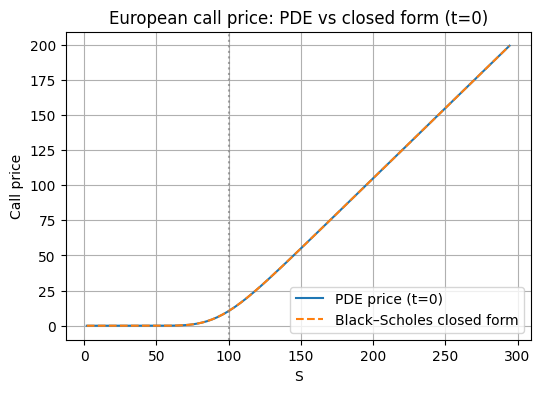

In [11]:
# Zoom range for plotting
S_min_plot = 0.0
S_max_plot = 300.0

mask = (S_grid >= S_min_plot) & (S_grid <= S_max_plot)

S_plot  = S_grid[mask]
V0_plot = V0[mask]
bs_plot = bs_prices[mask]

plt.figure(figsize=(6,4))
plt.plot(S_plot, V0_plot, label="PDE price (t=0)")
plt.plot(S_plot, bs_plot, "--", label="Black–Scholes closed form")
plt.axvline(S0, color="grey", linestyle=":", alpha=0.7)
plt.title("European call price: PDE vs closed form (t=0)")
plt.xlabel("S")
plt.ylabel("Call price")
plt.legend()
plt.grid(True)
plt.show()


The plot compares the PDE price at 𝑡 = 0
t=0 with the closed-form Black–Scholes price, restricted to the relevant range 𝑆 ∈[0,300].
The two curves are almost perfectly superimposed, showing that the numerical PDE solver reproduces the Black–Scholes formula with very high accuracy.
The kink at S=K=100 is clearly visible, and the zoom makes the agreement around the strike easy to inspect.

## 11.2 Absolute and relative errors

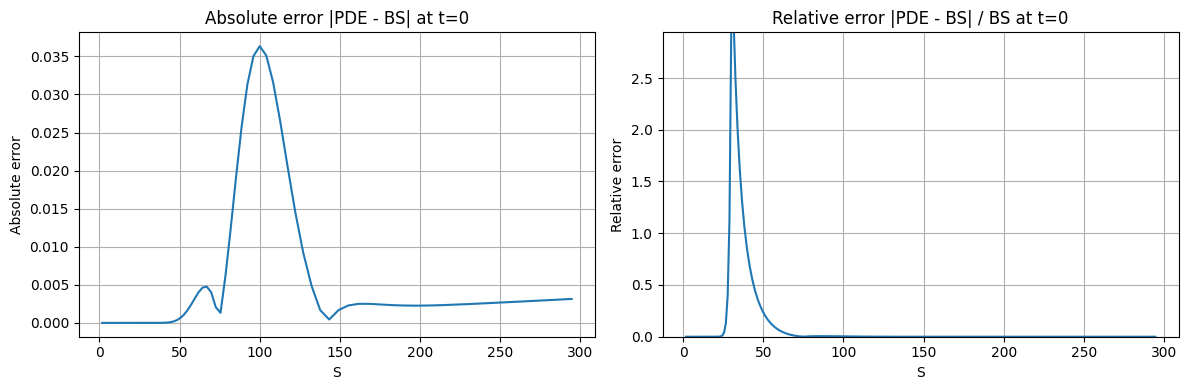

In [14]:
# Zoom range
S_min_plot = 0.0
S_max_plot = 300.0

mask = (S_grid >= S_min_plot) & (S_grid <= S_max_plot)

S_plot        = S_grid[mask]
abs_err_plot  = abs_err[mask]
rel_err_plot  = rel_err[mask]

plt.figure(figsize=(12,4))

# --- Absolute error ---
plt.subplot(1, 2, 1)
plt.plot(S_plot, abs_err_plot)
plt.title("Absolute error |PDE - BS| at t=0")
plt.xlabel("S")
plt.ylabel("Absolute error")
plt.grid(True)

# --- Relative error ---
plt.subplot(1, 2, 2)
plt.plot(S_plot, rel_err_plot)
plt.title("Relative error |PDE - BS| / BS at t=0")
plt.xlabel("S")
plt.ylabel("Relative error")
plt.ylim(0, np.percentile(rel_err_plot, 99))
plt.grid(True)

plt.tight_layout()
plt.show()


The absolute-error plot shows that the difference between the PDE price and the Black–Scholes closed form remains extremely small (below ≈0.04).  
The small peak near the strike $S \approx 100$ is expected: the payoff kink makes the PDE slightly harder to approximate there, but the error stays very low.

The relative-error plot confirms this behaviour: the relative error is essentially zero everywhere except for very small $S$, where the Black–Scholes price is itself almost zero. In that zone, even a tiny absolute error produces a large ratio, which is normal and not meaningful for pricing.

The PDE solver matches the Black–Scholes formula with **excellent accuracy** across the whole relevant range of $S$.


# 12. Visualising the solution surface

We now visualise the full $v(t,x)$ as a 3D surface.


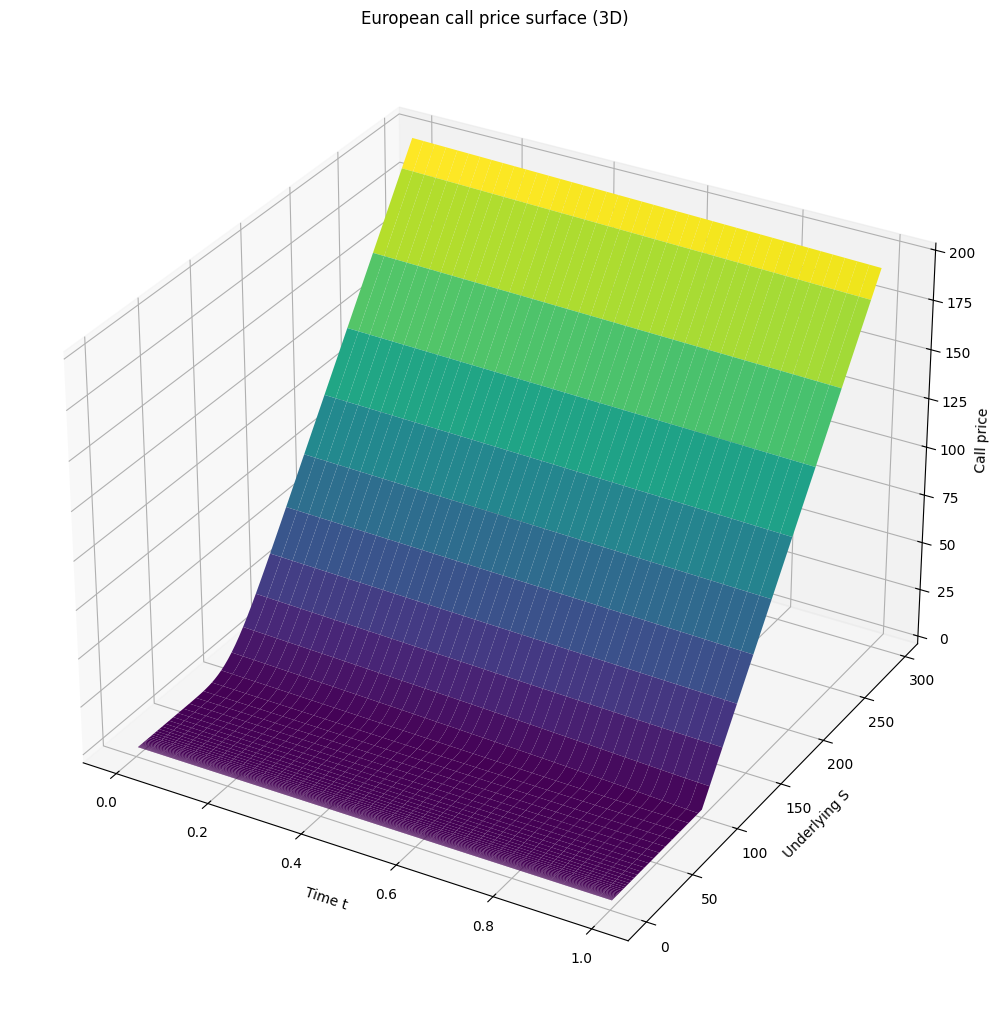

In [ ]:
# Zoom range
S_min_zoom = 0
S_max_zoom = 300

# Select indices in the S-grid
idx_zoom = (S_grid >= S_min_zoom) & (S_grid <= S_max_zoom)

S_zoom = S_grid[idx_zoom]
V_zoom = V[:, idx_zoom]

# Create meshgrid for 3D plot
T_mesh, S_mesh = np.meshgrid(t_grid, S_zoom)

# 3D surface plot
fig = plt.figure(figsize=(10, 40))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    T_mesh,
    S_mesh,
    V_zoom.T,
    cmap="viridis",
    linewidth=0,
    antialiased=True
)

ax.set_xlabel("Time t")
ax.set_ylabel("Underlying S")
ax.set_zlabel("Call price")
ax.set_title("European call price surface (3D)")

plt.tight_layout()
plt.show()